# Is it a bird?

## Install dependencies

In [1]:
!pip install -Uqq fastai duckduckgo_search

## Downloading images of birds and non-birds

In [2]:
from duckduckgo_search import ddg_images
from fastcore.all import *

def search_images(term, max_images=30):
    print(f"Searching for {term}")
    return L(ddg_images(term, max_results=max_images)).itemgot("image")

In [3]:
urls = search_images(term="bird", max_images=1)
urls[0]

Searching for bird


/opt/conda/lib/python3.10/site-packages/duckduckgo_search/compat.py:60: UserWarning: ddg_images is deprecated. Use DDGS().images() generator
  warnings.warn("ddg_images is deprecated. Use DDGS().images() generator")
/opt/conda/lib/python3.10/site-packages/duckduckgo_search/compat.py:64: UserWarning: parameter page is deprecated
  warnings.warn("parameter page is deprecated")
/opt/conda/lib/python3.10/site-packages/duckduckgo_search/compat.py:66: UserWarning: parameter max_results is deprecated
  warnings.warn("parameter max_results is deprecated")


'https://images.alphacoders.com/492/492674.jpg'

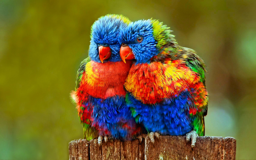

In [4]:
from fastdownload import download_url
from fastai.vision.all import *

download_url(url=urls[0], dest="data/bird.jpg", show_progress=False)

im = Image.open("data/bird.jpg")
im.to_thumb(256, 256)

Searching for forest photos


/opt/conda/lib/python3.10/site-packages/duckduckgo_search/compat.py:60: UserWarning: ddg_images is deprecated. Use DDGS().images() generator
  warnings.warn("ddg_images is deprecated. Use DDGS().images() generator")
/opt/conda/lib/python3.10/site-packages/duckduckgo_search/compat.py:64: UserWarning: parameter page is deprecated
  warnings.warn("parameter page is deprecated")
/opt/conda/lib/python3.10/site-packages/duckduckgo_search/compat.py:66: UserWarning: parameter max_results is deprecated
  warnings.warn("parameter max_results is deprecated")


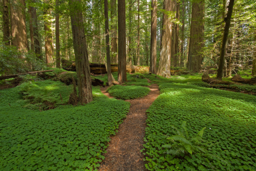

In [5]:
download_url(url=search_images(term="forest photos", max_images=1)[0], dest="data/forest.jpg", show_progress=False)
im = Image.open("data/forest.jpg")
im.to_thumb(256, 256)

In [6]:
import os
from time import sleep

directory_path = "bird_or_not"
search_terms = ["bird", "forest"]
path = Path("bird_or_not")

if os.path.exists(directory_path) and any(os.scandir(directory_path)):
    print("Dataset already downloaded!")
else:
    print("Downloading dataset...")
    for search_term in search_terms:
        dest = (path/search_term)
        dest.mkdir(exist_ok=True, parents=True)
        download_images(dest=dest, urls=search_images(f"{search_term} photo"))
        sleep(10)
        download_images(dest=dest, urls=search_images(f"{search_term} sun photo"))
        sleep(10)
        download_images(dest=dest, urls=search_images(f"{search_term} shade photo"))
        sleep(10)
        resize_images(path/search_term, max_size=400, dest=path/search_term)

Dataset already downloaded!


## Train our model

In [7]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

0

In [8]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method="squish")]
).dataloaders(path, bs=32)

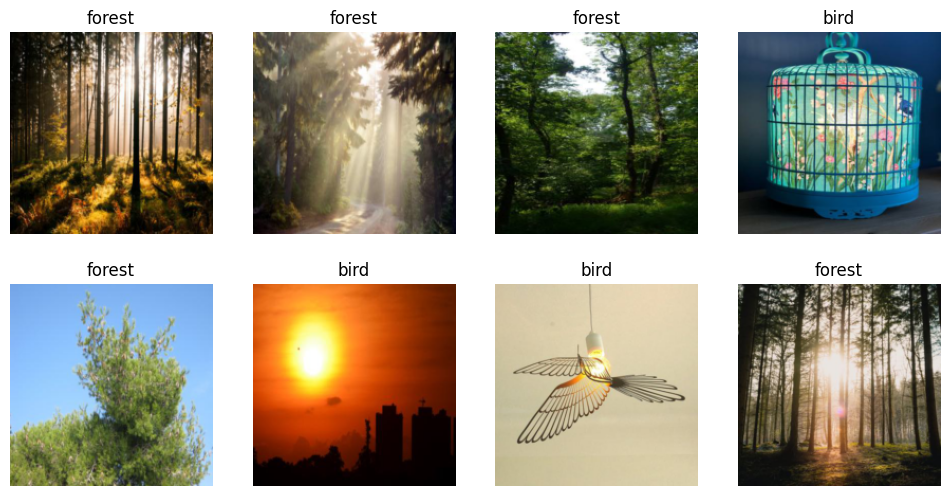

In [9]:
dls.show_batch(max_n=8)

In [10]:
learner = vision_learner(dls, resnet34, metrics=error_rate)
learner.fine_tune(3)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,1.077548,0.198962,0.029412,00:10


epoch,train_loss,valid_loss,error_rate,time
0,0.214276,0.044930,0.029412,00:09
1,0.111503,0.025310,0.000000,00:08
2,0.083090,0.034547,0.029412,00:09


## Use our model

In [11]:
is_bird, _, probs = learner.predict(PILImage.create("data/bird.jpg"))
print(f"This is a {is_bird}!")
print(f"Probability this is a bird is: {probs[0]:.4f}")

This is a bird!
Probability this is a bird is: 0.9996
